In [1]:
# this file will:
    #1. load data
    #2. data augmentation
    #3. preprocess (scaling on label)
    #4. training the network on training data(use DL notebook from w4)
    #5. test (use DL notebook from w4)

In [2]:
# Import cell
import torch
import torch.nn as nn
import math
import numpy as np
from collections import OrderedDict

import torchvision.transforms as transforms
import torchvision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns

# image loading
import os
from PIL import Image

# training process
from sklearn import model_selection

import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim

from sklearn import metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
################## DATA LOADERS ###############
def read_img(root, filedir, transform=None):
    # Data loading
    with open(filedir, 'r') as f:
        lines = f.readlines()  
    output = []    
    for line in lines:
        linesplit = line.split('\n')[0].split(' ')
        #print(linesplit)
        addr = linesplit[0]
        target = torch.Tensor([float(linesplit[1])])
        img = Image.open(os.path.join(root, addr)).convert('RGB')

        if transform is not None:
            img = transform(img)
        
        output.append([img, target])

    return output


################## DATA ANALYSIS ###############
def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()
        
################## PERFORMANCE ANALYSIS ###############      
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

In [5]:
################## AlexNet ##################
def bn_relu(inplanes):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True))

def bn_relu_pool(inplanes, kernel_size=3, stride=2):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=kernel_size, stride=stride))

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, bias=False)
        self.relu_pool1 = bn_relu_pool(inplanes=96)
        self.conv2 = nn.Conv2d(96, 192, kernel_size=5, padding=2, groups=2, bias=False)
        self.relu_pool2 = bn_relu_pool(inplanes=192)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu3 = bn_relu(inplanes=384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu4 = bn_relu(inplanes=384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu_pool5 = bn_relu_pool(inplanes=256)
        # classifier
        self.conv6 = nn.Conv2d(256, 256, kernel_size=5, groups=2, bias=False)
        self.relu6 = bn_relu(inplanes=256)
        self.conv7 = nn.Conv2d(256, num_classes, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu_pool1(x)
        x = self.conv2(x)
        x = self.relu_pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu_pool5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = x.view(x.size(0), -1)
        return x

In [6]:
# Scaling of data
#file_in = './data/1/morph_all_label.txt'
file_in = 'image_label_mapping.txt'
mylines = []                             # Declare an empty list named mylines.
with open(file_in, 'rt') as myfile: # Open lorem.txt for reading text data.
    for myline in myfile:                # For each line, stored as myline,
        mylines.append(float(myline.split()[1]))       # add its contents to mylines.

min_val = min(mylines)
max_val = max(mylines)
lower_scale = 0
upper_scale = 4

for i in range(len(mylines)):
    mylines[i] = int(np.round(((upper_scale-lower_scale)*((mylines[i]-min_val)/(max_val-min_val)))+lower_scale))
    
print(mylines)

[2, 0, 1, 1, 2, 0, 0, 2, 0, 4, 1, 1, 2, 1, 1, 3, 2, 2, 1, 3, 3, 1, 1, 2, 3, 1, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 0, 3, 3, 4, 3, 4, 3, 3, 4, 4, 4, 3, 2, 3, 3, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 

In [7]:
# Storing scaled data to images
file_out = 'image_label_mapping_scaled.txt'

cntr = 0
with open(file_in, 'r') as f_in:
    with open(file_out, 'w') as f_out:
        for line in f_in:
            image_name = line.split()[0] + ' '
            rating = mylines[cntr]
            
            f_out.write(image_name+str(rating)+'\n')
            cntr+=1

In [8]:
#def main():
# net definition 
net = AlexNet()
device = torch.device('cpu')  # use cuda or cpu
net.to(device)

# evaluate
net.eval()

root = 'C:/Users/Lenovo/Documents/AdvancedProject/NeuralNetwork/data/dataset'
valdir = 'image_label_mapping_scaled.txt'

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])  
data = read_img(root, valdir, transform=transform)


In [9]:
for i in range(len(data)):
    data[i][1] = int(data[i][1].numpy()[0])
    
data

[[tensor([[[-0.6794, -0.7137, -0.7308,  ..., -0.7650, -0.7308, -0.7822],
           [-0.6965, -0.7308, -0.7479,  ..., -0.7993, -0.7650, -0.7479],
           [-0.7137, -0.7308, -0.7479,  ..., -0.8164, -0.7822, -0.7308],
           ...,
           [-0.4054, -0.4739, -0.5082,  ..., -0.6794, -0.6281, -0.5596],
           [-0.3883, -0.4568, -0.4911,  ..., -0.6452, -0.6281, -0.5938],
           [-0.3883, -0.4739, -0.4739,  ..., -0.6623, -0.6109, -0.5938]],
  
          [[-0.8102, -0.8627, -0.8803,  ..., -0.8978, -0.8627, -0.8978],
           [-0.8452, -0.8627, -0.8803,  ..., -0.9328, -0.8978, -0.8803],
           [-0.8452, -0.8627, -0.8803,  ..., -0.9503, -0.9328, -0.8803],
           ...,
           [-0.6702, -0.7052, -0.7227,  ..., -0.8452, -0.8102, -0.7577],
           [-0.6877, -0.7052, -0.7227,  ..., -0.8277, -0.8102, -0.7927],
           [-0.6527, -0.7227, -0.7227,  ..., -0.8277, -0.7927, -0.7752]],
  
          [[-0.8807, -0.9330, -0.9330,  ..., -0.9853, -0.9678, -0.9853],
           

In [10]:
for i, d in enumerate(data):
    data[i] = tuple(d)

In [11]:
# Train test split, we can also use tf.split() but it doesn't support percentage split??
train_set = data[:500]
test_set = data[500:600]

In [12]:
type(train_set[0][0])

torch.Tensor

In [13]:
len(train_set)

500

In [14]:
type(test_set[0][0])

torch.Tensor

In [15]:
batch_size = 25 # try this out for training

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

In [16]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = 5
classes = list(range(5))
classes

Training data
Number of points: 500
Batch dimension (B x C x H x W): torch.Size([25, 3, 224, 224])

Test data
Number of points: 100
Batch dimension (B x C x H x W): torch.Size([25, 3, 224, 224])


[0, 1, 2, 3, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


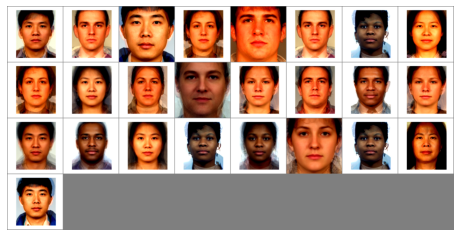

tensor([2, 2, 1, 1, 1, 2, 4, 2, 1, 3, 2, 0, 3, 1, 2, 3, 3, 3, 4, 4, 4, 3, 4, 1,
        1])

In [17]:
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))
labels

In [18]:
# Define a loss function

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum = 0.9)

In [19]:
# Test the forward pass with dummy data
out = net(torch.randn(2, 3, 224, 224, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 5])
Output logits:
[[ 0.00142639  0.00857877  0.00264484  0.01388054 -0.01591801]
 [ 0.00133658  0.00938196  0.00446782  0.01430643 -0.01289811]]
Output probabilities:
[[0.19985075 0.20128527 0.2000944  0.20235528 0.19641435]
 [0.19959544 0.20120774 0.2002214  0.20220102 0.1967744 ]]


In [20]:
batch_size = 64
num_epochs = 30
validation_every_steps = 10

step = 0
net.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    print(epoch)
    train_accuracies_batches = []
    print(len(train_loader))
    for inputs, targets in train_loader:
        #print('hér')
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!

        # Forward
        output = net(inputs)
        loss = loss_fn(output, targets)   
        
        # backward
        loss.backward()

        # optimize
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                net.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

0
20
Step 10      training accuracy: 0.5119999999999999
             test accuracy: 0.18
Step 20      training accuracy: 0.688
             test accuracy: 0.18
1
20
Step 30      training accuracy: 0.716
             test accuracy: 0.18
Step 40      training accuracy: 0.8320000000000001
             test accuracy: 0.46
2
20
Step 50      training accuracy: 0.8640000000000001
             test accuracy: 0.45
Step 60      training accuracy: 0.868
             test accuracy: 0.46
3
20
Step 70      training accuracy: 0.9
             test accuracy: 0.46
Step 80      training accuracy: 0.8760000000000001
             test accuracy: 0.19
4
20
Step 90      training accuracy: 0.908
             test accuracy: 0.46
Step 100     training accuracy: 0.916
             test accuracy: 0.46
5
20
Step 110     training accuracy: 0.9080000000000001
             test accuracy: 0.55
Step 120     training accuracy: 0.916
             test accuracy: 0.28
6
20
Step 130     training accuracy: 0.96
             